In [1]:
## 1. Import Libraries & Create Titanic-like Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import joblib

In [2]:
# Create a small synthetic Titanic-like dataset
np.random.seed(42)
n_samples = 300

data = {
    'Pclass': np.random.choice([1, 2, 3], n_samples, p=[0.2, 0.3, 0.5]),
    'Sex': np.random.choice(['male', 'female'], n_samples),
    'Age': np.random.normal(30, 14, n_samples),
    'SibSp': np.random.randint(0, 4, n_samples),
    'Fare': np.random.normal(50, 20, n_samples)
}

df = pd.DataFrame(data)

In [3]:
# Clip age and fare to realistic bounds
df['Age'] = df['Age'].clip(0, 80)
df['Fare'] = df['Fare'].clip(5, 250)

# Create a synthetic Survived column based on some heuristics + noise
survival_prob = (
    (df['Pclass'].map({1: 0.6, 2: 0.4, 3: 0.2})) +
    (df['Sex'].map({'female': 0.3, 'male': -0.1})) -
    (df['SibSp'] * 0.05)
)

In [4]:
survival_prob = 1 / (1 + np.exp(-survival_prob))  # sigmoid
df['Survived'] = (np.random.rand(n_samples) < survival_prob).astype(int)

# Introduce some missing values for Age and Fare
mask_age = np.random.rand(n_samples) < 0.1
mask_fare = np.random.rand(n_samples) < 0.05
df.loc[mask_age, 'Age'] = np.nan
df.loc[mask_fare, 'Fare'] = np.nan

df.head()

,Pclass,Sex,Age,SibSp,Fare,Survived
0,2,male,34.352706,2,64.155039,0
1,3,female,50.654987,2,38.750664,1
2,3,female,42.007235,1,62.648155,1
3,3,female,27.760861,1,69.451089,1
4,1,male,29.733773,3,62.436199,1


Shape: (300, 6)
\nMissing values:
Pclass       0
Sex          0
Age         35
SibSp        0
Fare        11
Survived     0
dtype: int64
\nClass balance (Survived):
Survived
1    174
0    126
Name: count, dtype: int64


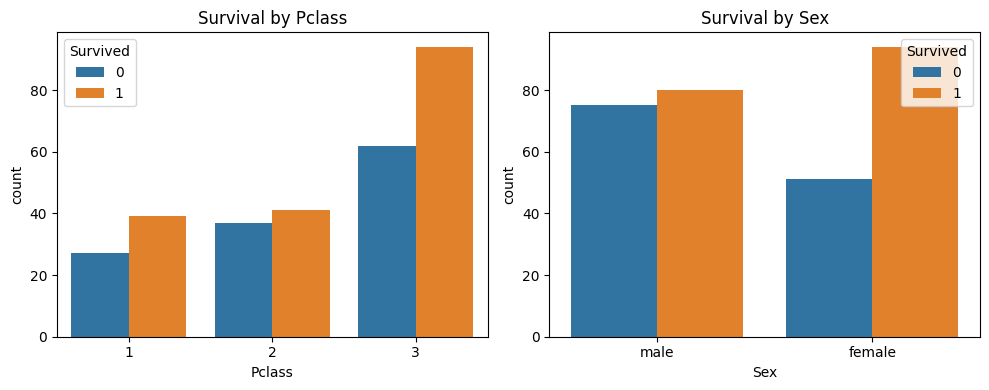

In [6]:
## 2. Basic EDA
print("Shape:", df.shape)
print("\\nMissing values:")
print(df.isnull().sum())

print("\\nClass balance (Survived):")
print(df['Survived'].value_counts())

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.countplot(data=df, x='Pclass', hue='Survived')
plt.title('Survival by Pclass')

plt.subplot(1,2,2)
sns.countplot(data=df, x='Sex', hue='Survived')
plt.title('Survival by Sex')

plt.tight_layout()
plt.show()

In [7]:
## 3. Handle Missing Values
# Fill missing Age with median, Fare with mean
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Fare'].fillna(df['Fare'].mean(), inplace=True)

df.isnull().sum()

C:\Users\Kushagra Bhardwaj\AppData\Local\Temp\ipykernel_23412\1170302721.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
C:\Users\Kushagra Bhardwaj\AppData\Local\Temp\ipykernel_23412\1170302721.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

Pclass      0
Sex         0
Age         0
SibSp       0
Fare        0
Survived    0
dtype: int64

In [8]:
## 4. Encoding & Feature Selection
# Encode 'Sex' using LabelEncoder
le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])  # female=0, male=1 (typically)

# Features and target
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Fare']
X = df[features]
y = df['Survived']

X.head()

,Pclass,Sex,Age,SibSp,Fare
0,2,1,34.352706,2,64.155039
1,3,0,50.654987,2,38.750664
2,3,0,42.007235,1,62.648155
3,3,0,27.760861,1,69.451089
4,1,1,29.733773,3,62.436199


In [9]:
## 5. Train-Test Split & Scaling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
## 6. Train Models — Logistic Regression & Random Forest
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train_scaled, y_train)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)  # tree-based models handle unscaled features fine

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [11]:
# Predictions
y_pred_lr = log_reg.predict(X_test_scaled)
y_pred_rf = rf.predict(X_test)

In [12]:
# Metrics
acc_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

In [15]:
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print(f"Logistic Regression - Accuracy: {acc_lr:.3f}, F1: {f1_lr:.3f}")
print(f"Random Forest       - Accuracy: {acc_rf:.3f}, F1: {f1_rf:.3f}")

Logistic Regression - Accuracy: 0.583, F1: 0.691
Random Forest       - Accuracy: 0.400, F1: 0.514


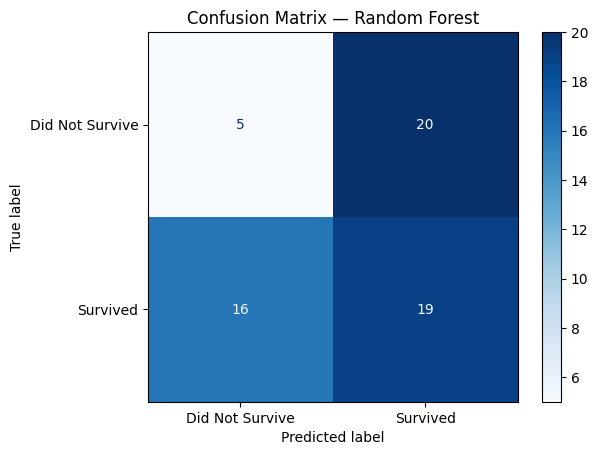

In [16]:
## 7. Confusion Matrix (Random Forest)
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Did Not Survive', 'Survived'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix — Random Forest')
plt.show()

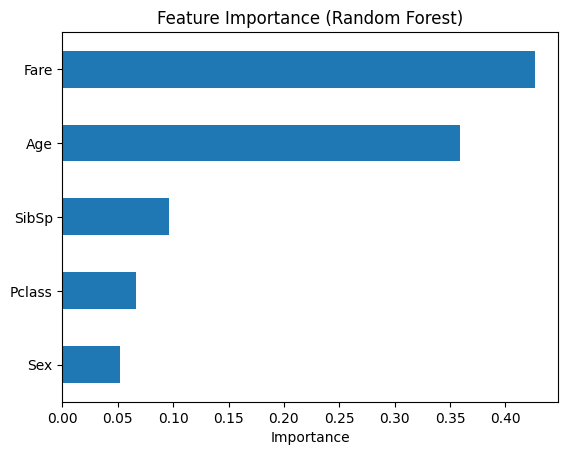

In [17]:
## 8. Feature Importance (Random Forest)
importances = pd.Series(rf.feature_importances_, index=features)
importances.sort_values().plot(kind='barh')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.show()

In [18]:
## 9. Save Best Model & Scaler
# Assume Random Forest is best here
joblib.dump(rf, 'titanic_rf_model.joblib')
joblib.dump(scaler, 'titanic_scaler.joblib')

print('Models saved successfully!')
print('- titanic_rf_model.joblib')
print('- titanic_scaler.joblib')

Models saved successfully!
- titanic_rf_model.joblib
- titanic_scaler.joblib


In [20]:
## 10. Load Model & Predict on New Passenger
loaded_model = joblib.load('titanic_rf_model.joblib')
loaded_scaler = joblib.load('titanic_scaler.joblib')

# Example passenger: 3rd class, male, 25 years, 1 sibling/spouse, low fare
sample = pd.DataFrame([{
    'Pclass': 3,
    'Sex': 1,
    'Age': 25,
    'SibSp': 1,
    'Fare': 20
}])

In [21]:
sample_scaled = loaded_scaler.transform(sample[features])
pred = loaded_model.predict(sample[features])[0]

print('Prediction (1=Survived, 0=Not Survived):', pred)

Prediction (1=Survived, 0=Not Survived): 0
